# Building a Decision Using the Decision Science Framework

The goal of the Decision Science Framework (DSF) is to provide a general, but accessible framework to ease the burdon of using quantitative decision making methods. This short tutorial will walk through the creation of a decision using the DSF from scratch.  We'll take this process all the way through to the measurement of information values. 

In [1]:
from DecisionScienceFramework.decision import Decision
# Initialize the decision object with a name and fp where we'll save our progress
school_decision = Decision("School Decision", fp="C:\\Users\\perus\\GitHub\\Decision-Science-Framework")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Recreating the Decision Model sample

In this decision we are choosing between two different recruitment strategies.  We might either hire new staff to actively recuit folks through different engagement strategies, or we could employ a digital media strategy that doesn't actually require more staff but has costs involved in purchasing the service.

The base cost for either strategy is $1,000,000.  For each strategy we then want to consider the probability that we are over/under budget and the effictiveness of either strategy.

In [2]:
# For the hiring strategy, we consider the distribution that we are over/under the base 
# cost.  So in this case, we might be $20,000 under or $400,000 over.
school_decision.add_variable_from_ci("HiringCostOver", lower=-100000, upper=400000, dist="Normal")
# We also want to capture their effectiveness
school_decision.add_variable_from_ci("HiringEffectiveness", lower=30, upper=300, mode=80, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 569.337410
         Iterations: 105
         Function evaluations: 202


In [3]:
# Okay, now we want to create similar variables but for the digital marketing strategy
school_decision.add_variable_from_ci("MarketingCostOver", lower=-20000, upper=80000, dist="Normal")
school_decision.add_variable_from_ci("MarketingEffectiveness", lower=45, upper=90, mode=60, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 16.394315
         Iterations: 88
         Function evaluations: 173


In [4]:
# Now that we've established costs and effectiveness, we just need to add someway to translate
# the number of additional ACMs recruited to a monetary value 
school_decision.add_variable_from_ci("ACMValueAdd", lower=3000, upper=48000, mode=9200, dist='Lognormal')

Optimization terminated successfully.
         Current function value: 17309836.200198
         Iterations: 127
         Function evaluations: 248


In [5]:
# These are the last of our random variables.  Before defining any further deterministic variables,
# like the loss function, we will need to sample.
school_decision.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [ACMValueAdd_log__, MarketingEffectiveness_log__, MarketingCostOver, HiringEffectiveness_log__, HiringCostOver]
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1166.22it/s]


In [6]:
school_decision.add_variable_from_patsy("HireCost", "-1000000 - HiringCostOver")
school_decision.add_variable_from_patsy("HireBenefit", "ACMValueAdd * HiringEffectiveness")
school_decision.add_variable_from_patsy("HireNet", "HireCost + HireBenefit")

In [7]:
school_decision.add_variable_from_patsy("MarketingCost", "-1000000 - MarketingCostOver")
school_decision.add_variable_from_patsy("MarketingBenefit", "ACMValueAdd * MarketingEffectiveness")
school_decision.add_variable_from_patsy("MarketingNet", "MarketingCost + MarketingBenefit")

In [8]:
# Our choice of loss functions builds in our default choice.  By convention, we want to minimize loss.  Therefore high values 
# of loss are undesirable.  So, if our default decision is to Hire.  Then the opportunity loss is expressed by any beneft that
# Marketing may have had over Hiring. 
school_decision.set_loss("MarketingNet - HireNet")

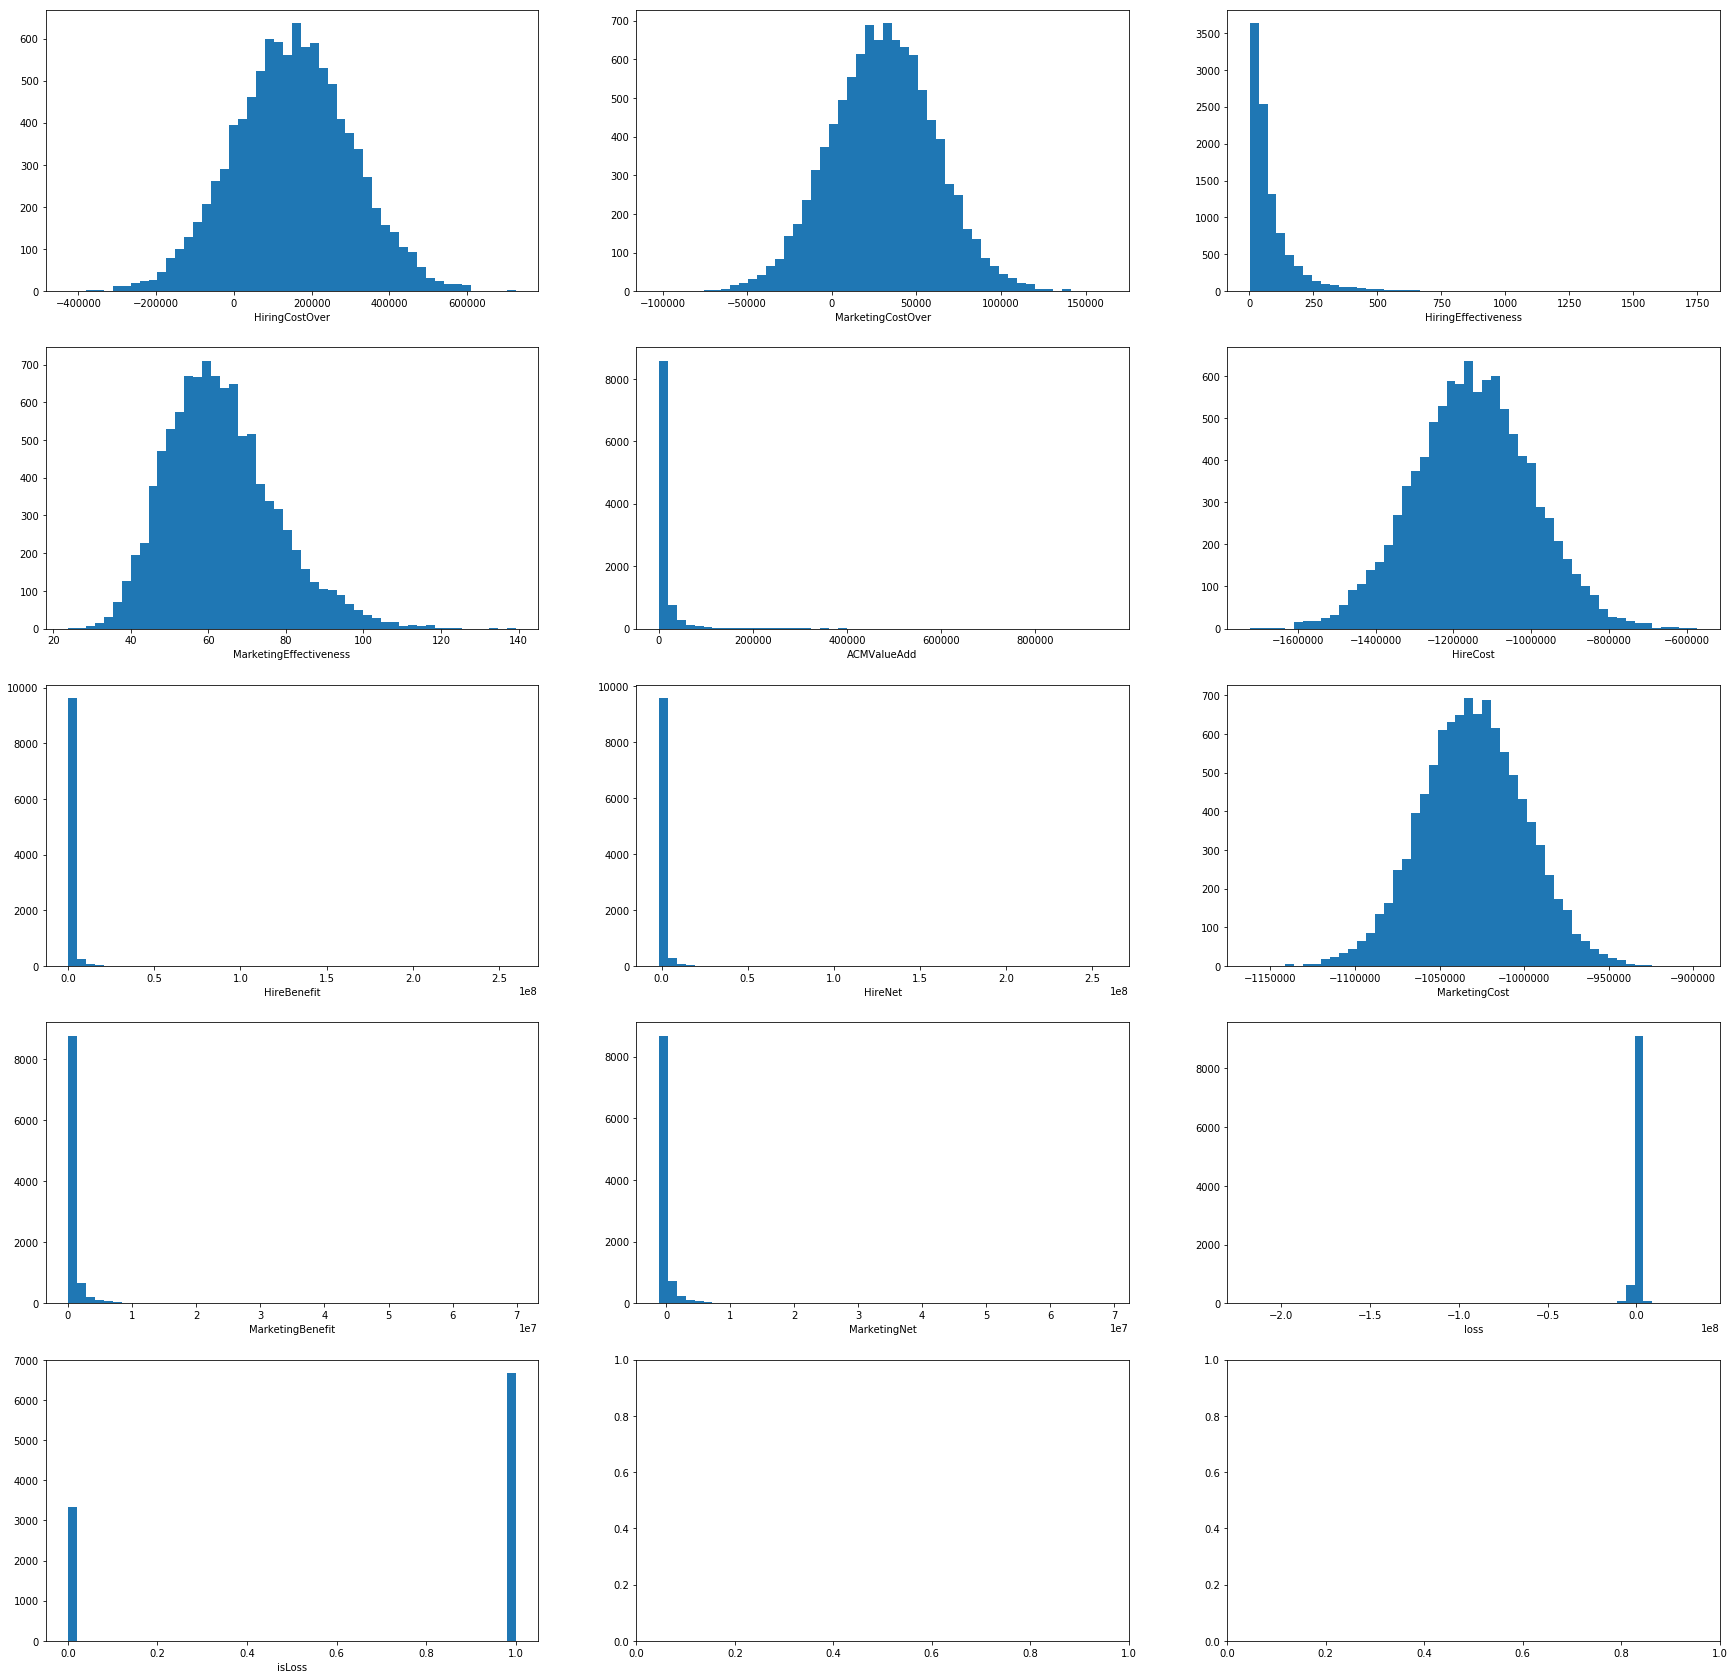

In [10]:
school_decision.plot_variables()

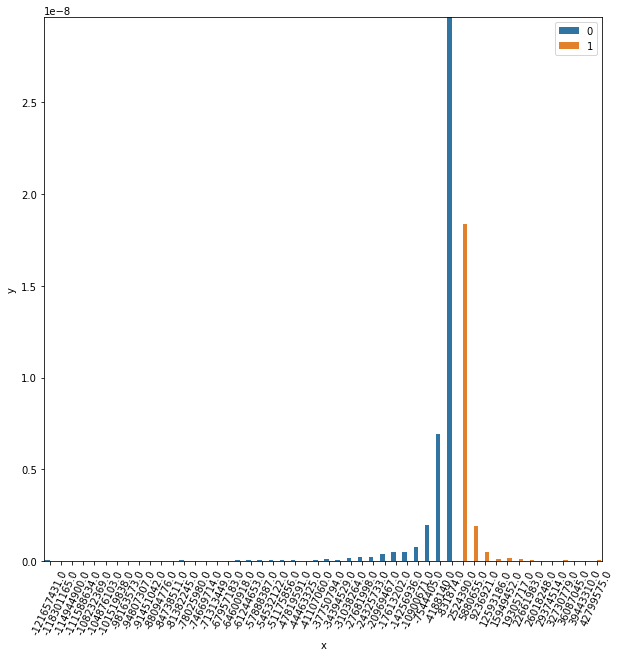

In [11]:
# Many negative options means that 
school_decision.plot_loss()

In [11]:
school_decision.evpi()

HiringCostOver: 11564.70319345122
HiringEffectiveness: 256631.3790545991
MarketingCostOver: 393.83667111146497
MarketingEffectiveness: 4176.371168812562
ACMValueAdd: 21437.851545117912


In [15]:
# Expected Loss.  This was the average loss over all of our simulations. 
# With it being negative, we're inclined to stick with our default, which was marketing.
school_decision.last_run.loss.mean()

-229100.0707182531

In [13]:
# Even with a mean that is favorable, our variance allows for possibilities where
# hiring does better.
school_decision.last_run.loss.std()

4794557.474306013

In [39]:
# In face, it's 34% of the time that Hiring does better.
school_decision.last_run.isLoss.mean()

0.34

In [31]:
# Total loss given that we choose Marketing
school_decision.last_run[school_decision.last_run.isLoss == 1].loss.mean()

-1831508.1008010048

In [32]:
# Total loss given that we choose Marketing
school_decision.last_run[school_decision.last_run.isLoss == 0].loss.mean()

500713.15795634745

In [24]:
school_decision.last_run.loss.mean()

-292242.0700211502

In [112]:
school_decision.last_run.loss.mean()

-251310.60329063085

In [14]:
school_decision.last_run.loss.std()

5144533.42696141